# Reverse Geocoder with OSM data
This notebook is to build reverse geocoder to response location address name from latitude and longitude that a user inputs. Source of the geolocation data comes from OpenStreetMap.

**NOTE**: This script was tested with only OSM Japan and kanto regions data.

Here are rough steps
1. Download and decompress OSM file of a region
2. Extract shape data of all administrative boundaries from OSM file, such as prefecture, city, town, and so on.
3. Create bounding box data per administrative boundary, and make 2 sorted lists of all bounding boxes. One is sorted by latitude and the other is by longitude. If a user requests with latitude and longitude, it retrieves matching boxes by latitude and longitude seperately, and intersects the result sets as candidates for the next step.
<img src="./img/boundingbox.png">
4. Create line list consisting per administrative boundary, and sort the list by latitude. Each line is a vector from Node\[i\] to Node\[i+1\]. This is used to judge if a line is right or left side against latitude & longitude user inputs. First it retrieves all lines covering user's latitude. Then it calculates cross of 2 vectors per line. One vector is from user's latitude & longitude to start point of the line (=Node\[i\]), the other is from user's latitude & longitude to the other end point(=Node\[i+1\]). If value of the cross is positive, the line is on the right from user's latitude & longitude. Otherwise it's on the left.
<img src="./img/cross.png">
Then imagine holizontal line from user's latitude and longitude to infinity, and count the intersections of the lines consisting of the boundary. If the number is odd, user's latitude is inside of the boundary. Otherwise it's outside.
<img src="./img/intersections.png">


In [4]:
import bisect
import bz2
import codecs
import copy
import datetime
import itertools
import json
import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import pandas as pd
import re
import pickle
import sys
import time
import unicodedata
import urllib.request
import xml.etree.ElementTree as ET

import logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.WARNING)

projectDir = 'ReverseGeocoder'


## download and decompress OSM file

In [5]:
url = 'http://download.geofabrik.de/asia/japan-latest.osm.bz2'
#url = 'http://download.geofabrik.de/asia/japan/kanto-latest.osm.bz2'

compressedFile = os.path.join(projectDir, url.split("/")[-1])
osmFile = compressedFile.replace('.bz2', '')

if not os.path.exists(osmFile):
    logging.info("start downloading []".format(compressedFile))
    start = time.time()
    urllib.request.urlretrieve(url, compressedFile)
    logging.info("completed to download {}".format(compressedFile))
    with open(compressedFile, 'rb') as rf, open(osmFile, 'wb') as wf:
        wf.write(bz2.decompress(rf.read()))
    logging.info("completed to decompress to {}(elapsed time:{:.3f})".format(osmFile, time.time() - start))

## Iterator to extract partial element blocks as single XMLs

In [6]:
class XmlPartialExtractor:
    def __init__(self, filename, tag):
        self.filename = filename
        self.f = codecs.open(filename, "r", "utf-8")
        self.tag = tag
        self.tagOpener = '<{} '.format(tag)
        self.tagClosure = '</{}>'.format(tag)
        self.lineCount = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        line = self.f.readline()
        self.lineCount += 1
        inElement = False
        buffer = []
        while line:
            line = line.strip()
            if self.tagOpener in line:
                if line.endswith('/>'):
                    root = ET.fromstring('<root>' + line + '</root>')
                    if root:
                        return root
                    else:
                        logging.warining('failed to parse at line:{} in {}'.format(self.lineCount, self.filename))
                        inElement = False
                else:
                    inElement = True
                    buffer = []
            elif self.tagClosure in line:
                if inElement:
                    buffer.append(line)
                    buffer.insert(0, '<root>')
                    buffer.append('</root>')
                    root = ET.fromstring(''.join(buffer))
                    if root:
                        return root
                    else:
                        logging.warining('failed to parse at line:{} in {}'.format(self.lineCount, self.filename))
                        inElement = False
            if inElement:
                buffer.append(line)
            line = self.f.readline()
            self.lineCount += 1
        
        self.f.close()
        return None


In [7]:
def xmlToString(root):
    return ET.tostring(root, encoding='unicode')

## read OSM file and extract &lt;relation/&gt; blocks with 'boundary':'administrative'

In [8]:
adminBoundariesFile = os.path.join(projectDir, 'adminBoundaris.xml')

if not os.path.exists(adminBoundariesFile):
    logging.info("start extracting administrative boundary relation blocks from {}".format(osmFile))
    start = time.time()
    relationExtractor = XmlPartialExtractor(osmFile, 'relation')
    count = 0
    with codecs.open(adminBoundariesFile, "w", "utf-8") as wf:
        while True:
            try:
                root = next(relationExtractor)
                if not root:
                    break
                for child in root.findall('./relation')[0]:
                    if child.tag == 'tag' and 'k' in child.attrib and child.attrib['k'] == 'boundary' and 'v' in child.attrib and child.attrib['v'] == 'administrative':
                        wf.write(xmlToString(root) + '\n')
                        count += 1
            except StopIteration:
                break
    
    logging.info("completed to extract {:,} of administrative boundary relation blocks to {}(elapsed time:{:.3f})".format(count, adminBoundariesFile, time.time() - start))

## read OSM again to extract &lt;way/&gt; blocks in administrative boundary &lt;relation/&gt; blocks

In [9]:
memberWaysFile = os.path.join(projectDir, 'memberWays.xml')

if not os.path.exists(memberWaysFile):
    logging.info("start extracting member elements associated with administrative boundary relations from {}".format(osmFile))
    start = time.time()
    waySet = set()
    
    with codecs.open(adminBoundariesFile, "r", "utf-8") as f:
        line = f.readline()
        while line:
            root = ET.fromstring(line.strip())
            for child in root.findall('./relation')[0]:
                if 'type' in child.attrib and child.attrib['type'] == 'way' and 'ref' in child.attrib:
                    waySet.add(child.attrib['ref'])
            line = f.readline()
            
    logging.info('completed to extract {} unique ways from {}'.format(len(waySet), adminBoundariesFile))

    wayCount = 0
    with codecs.open(memberWaysFile, "w", "utf-8") as f:
        wayExtractor = XmlPartialExtractor(osmFile, 'way')
        while True:
            try:
                root = next(wayExtractor)
                if not root:
                    break
                way = root.findall('./way')[0]
                if 'id' in way.attrib and way.attrib['id'] in waySet:
                    f.write(xmlToString(root) + "\n")
                    wayCount += 1
            except StopIteration:
                break
                    
    logging.info('completed to extract {:,} member elements with type="way" to {}(elapsed time:{:.3f})'.format(wayCount, memberWaysFile, time.time() - start))


## class definitions of nodes, ways, relations of administrative boundaries

In [10]:
class Node:
    def __init__(self, id, lat, lon):
        self.id = id
        self.lat = lat
        self.lon = lon       

class Way:
    def __init__(self, id):
        self.id = id
        self.nodes = []

class AdminBoundary:
    def __init__(self, id):
        self.id = id
        self.name = None
        self.ways = []
        self.level = None
        self.latVertexes = []
        self.maxLatLen = 0
        self.lineDict = {}

## read OSM once more to extract &lt;node/&gt; blocks associated with administrative boundary &lt;way/&gt; blocks

In [11]:
memberNodesFile = os.path.join(projectDir, 'memberNodes.xml')
nodeDictFile = os.path.join(projectDir, 'nodeDict.pickle')
way2NodesDictFile = os.path.join(projectDir, 'way2NodesDict.pickle') 

start = time.time()

if not os.path.exists(nodeDictFile):
    logging.info('start extracting nodes pointed in boundaries ways to {} and {}'.format(nodeDictFile, way2NodesDictFile))
    nodeDict = {}
    way2NodesDict = {}
    nodeIdSet = set()

    with codecs.open(memberWaysFile, 'r', 'utf-8') as f:
        line = f.readline()
        while line:
            root = ET.fromstring(line.strip())
            if root:
                way = root.findall('./way')[0]
                if 'id' in way.attrib:
                    wayId = way.attrib['id']
                    way2NodesDict[wayId] = []
                    for child in way:
                        if child.tag == 'nd' and 'ref' in child.attrib:
                            nodeId = child.attrib['ref']
                            way2NodesDict[wayId].append(nodeId)
                            nodeIdSet.add(nodeId)
            line = f.readline()
            
    logging.info('completed to extract {:,} unique ways having {:,} unique nodes from {}'.format(len(way2NodesDict), len(nodeIdSet), memberWaysFile))

    with codecs.open(memberNodesFile, "w", "utf-8") as f:
        nodeExtractor = XmlPartialExtractor(osmFile, 'node')
        while True:
            try:
                root = next(nodeExtractor)
                if not root:
                    break
                node = root.findall('./node')[0]
                if 'id' in node.attrib:
                    nodeId = node.attrib['id']
                    if nodeId in nodeIdSet and 'lat' in node.attrib and 'lon' in node.attrib:
                        lat = float(node.attrib['lat'])
                        lon = float(node.attrib['lon'])
                        nodeDict[nodeId] = Node(nodeId, lat, lon)
                        f.write(xmlToString(root) + "\n")
            except StopIteration:
                break
            
    with open(nodeDictFile, 'wb') as f:
        pickle.dump(nodeDict, f)
    with open(way2NodesDictFile, 'wb') as f:
        pickle.dump(way2NodesDict, f)
    logging.info('completed to save nodeDict having {:,} items to {} and way2NodesDict having {:,} items to {}(elapsed time:{:.3f})'.format(len(nodeDict), nodeDictFile, len(way2NodesDict), way2NodesDictFile, time.time() - start))
else:
    with open(nodeDictFile, 'rb') as f:
        nodeDict = pickle.load(f)
    with open(way2NodesDictFile, 'rb') as f:
        way2NodesDict = pickle.load(f)
    logging.info('completed to load nodeDict having {:,} items to {} and way2NodesDict having {:,} items to {}(elapsed time:{:.3f})'.format(len(nodeDict), nodeDictFile, len(way2NodesDict), way2NodesDictFile, time.time() - start))


2020-08-25 12:48:48,058 : INFO : completed to load nodeDict having 2,876,747 items to ReverseGeocoder\nodeDict.pickle and way2NodesDict having 33,579 items to ReverseGeocoder\way2NodesDict.pickle(elapsed time:7.908)


## Vertex is used for sorted list of bounding boxes. KeyWrappers is for binary search of vertexes

In [12]:
class Vertex:
    def __init__(self, id, vtype, value):
        self.id = id
        self.vtype = vtype
        self.value = value
        
class KeyWrapper:
    def __init__(self, iterable, key):
        self.it = iterable
        self.key = key

    def __getitem__(self, i):
        return self.key(self.it[i])

    def __len__(self):
        return len(self.it)

In [13]:
def getLatLons(ab):
    return [[(node.lat, node.lon) for node in way.nodes] for way in ab.ways]

def getBoundingBox(latlons):
    lats = [lat for lat, _ in itertools.chain.from_iterable(latlons)]
    lons = [lon for _, lon in itertools.chain.from_iterable(latlons)]
    return min(lats), min(lons), max(lats), max(lons)

def getLines(latlons):
    lines = []
    for arr in latlons:
        for i in range(len(arr) - 1):
            lines.append(((arr[i][0], arr[i][1]), (arr[i + 1][0], arr[i + 1][1])))
    return lines

def getNodeDistance(node0, node1):
    return np.sqrt((node0.lat- node1.lat)**2 + (node0.lon - node1.lon)**2)

def getNodeDistance(node0, node1):
    return np.sqrt((node0.lat- node1.lat)**2 + (node0.lon - node1.lon)**2)

## create data about administrative boundaries

In [14]:
adminBoundaryDictFile = os.path.join(projectDir, 'adminBoundaryDict.pickle')
start = time.time()

if not os.path.exists(adminBoundaryDictFile):
    wayDict = {}
    adminBoundaryDict = {}

    for wayId, nodeIds in way2NodesDict.items():
        way = Way(wayId)
        for nodeId in nodeIds:
            if not nodeId in nodeDict:
                logging.warning("Node:{} of Way:{} is not found in nodeDict".format(nodeId, wayId))
            else:
                way.nodes.append(nodeDict[nodeId])
        wayDict[wayId] = way

    imcompleteRelationIdSet = set()
    missingWayIdSet = set()
    imcompleteRelationDict = {}

    with codecs.open(adminBoundariesFile, "r", "utf-8") as f:
        line = f.readline()
        while line:
            root = ET.fromstring(line.strip())
            if root:
                relation = root.findall('./relation')[0]
                if 'id' in relation.attrib:
                    relationId = relation.attrib['id']
                    adminBoundary = AdminBoundary(relationId)
                    missingWays = []
                    for child in relation:
                        if child.tag == 'member' and 'type' in child.attrib and child.attrib['type'] == 'way' and 'ref' in child.attrib:
                            wayId = child.attrib['ref']
                            if not wayId in wayDict:
                                imcompleteRelationIdSet.add(relationId)
                                missingWayIdSet.add(wayId)
                                imcompleteRelationDict[relationId] = wayId
                                missingWays.append(wayId)
                            else:
                                adminBoundary.ways.append(wayDict[wayId])
                        elif child.tag == 'tag':
                            if 'k' in child.attrib and child.attrib['k'] == 'name' and 'v' in child.attrib:
                                adminBoundary.name = child.attrib['v']
                            elif 'k' in child.attrib and child.attrib['k'] == 'admin_level' and 'v' in child.attrib:
                                adminBoundary.level = int(child.attrib['v'])
                    if not adminBoundary.name:
                        logging.warning("Id:{} has no name".format(adminBoundary.id))
                    elif missingWays:
                        logging.warning("Id:{} Name:{} has missing way(s):{}".format(adminBoundary.id, adminBoundary.name, ','.join(missingWays)))
                    elif not adminBoundary.level or adminBoundary.level < 4:
                        logging.warning("Id:{} Name:{} has no level or the level < 4".format(adminBoundary.id, adminBoundary.name))
                    else:
                        latlons = getLatLons(adminBoundary)
                        if len(latlons) <= 2:
                            logging.warning("Id:{} Name:{} has only {:,} latlon(s)".format(adminBoundary.id, adminBoundary.name, len(latlons)))
                        else:
                            for id, ((lat0, lon0), (lat1, lon1)) in enumerate(getLines(latlons)):
                                if lat0 > lat1:
                                    lat0, lat1 = lat1, lat0
                                    lon0, lon1 = lon1, lon0
                                if lat1 - lat0 > adminBoundary.maxLatLen:
                                    adminBoundary.maxLatLen = lat1 - lat0
                                adminBoundary.latVertexes.append(Vertex(id, 'start', lat0))
                                adminBoundary.latVertexes.append(Vertex(id, 'end', lat1))
                                adminBoundary.lineDict[id] = ((lat0, lon0), (lat1, lon1))
                            adminBoundary.latVertexes.sort(key=lambda v: v.value)
                            adminBoundaryDict[adminBoundary.id] = adminBoundary
            line = f.readline()

    if len(imcompleteRelationDict) > 0:
        logging.warning("There are {:,} of imcomplete relations and {:,} of missing ways. Please check imcompleteRelationIdSet, missingWayIdSet, and imcompleteRelationDict for the details".format(len(imcompleteRelationIdSet), len(missingWayIdSet)))

    with open(adminBoundaryDictFile, 'wb') as f:
        pickle.dump(adminBoundaryDict, f)
    logging.info('completed to save adminBoundaryDict having {:,} items to {}(elapsed time:{:.3f})'.format(len(adminBoundaryDict), adminBoundaryDictFile, time.time() - start))
else:
    with open(adminBoundaryDictFile, 'rb') as f:
        adminBoundaryDict = pickle.load(f)
    logging.info('completed to load adminBoundaryDict having {:,} items to {}(elapsed time:{:.3f})'.format(len(adminBoundaryDict), adminBoundaryDictFile, time.time() - start))
    
    

2020-08-25 12:49:37,686 : INFO : completed to load adminBoundaryDict having 10,603 items to ReverseGeocoder\adminBoundaryDict.pickle(elapsed time:49.549)


## function to draw an administrative boundary

In [15]:
def drawAdminBoundary(ab, title=None, lat=None, lon=None):
    latlons = getLatLons(ab)
    lat0, lon0, lat1, lon1 =  getBoundingBox(latlons)
    if lat1 - lat0 > lon1 - lon0:
        length = lat1 - lat0
        latStart = lat0 - length * 0.05
        lonStart = (lon0 + lon1 - length) / 2
    else:
        length = lon1 - lon0
        lonStart = lon0 - length * 0.05
        latStart = (lat0 + lat1 - length) / 2
    latEnd = latStart + length * 1.1
    lonEnd = lonStart + length * 1.1
    
    fig = plt.figure(figsize=(6, 6))
    axis = fig.add_subplot(111, xlim=(lonStart, lonEnd), ylim=(latStart, latEnd))
    for arr in latlons:
        axis.plot([k[1] for k in arr], [k[0] for k in arr], color='black')
    if lat and lon:
        axis.scatter(lon, lat, color='red', s=100)
    if title:
        plt.title(title, fontname='MS Gothic')
    plt.show()

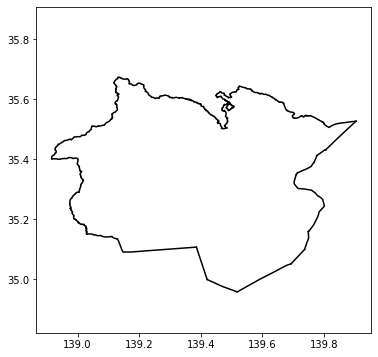

In [16]:
# test
ab = adminBoundaryDict['2689487']
drawAdminBoundary(ab)
    

## create bounding boxes data

In [17]:
boundingBoxesFile = os.path.join(projectDir, 'boundingBoxes.pickle')
start = time.time()

if not os.path.exists(boundingBoxesFile):
    maxLatLen = 0.
    maxLonLen = 0.
    bbLatList = []
    bbLonList = []

    for ab in adminBoundaryDict.values():
        latlons = getLatLons(ab)
        lat0, lon0, lat1, lon1 = getBoundingBox(latlons)
        bbLatList.append(Vertex(ab.id, 'start', lat0))
        bbLatList.append(Vertex(ab.id, 'end', lat1))
        bbLonList.append(Vertex(ab.id, 'start', lon0))
        bbLonList.append(Vertex(ab.id, 'end', lon1))
        if lat1 - lat0 > maxLatLen:
            maxLatLen = lat1 - lat0
        if lon1 - lon0 > maxLonLen:
            maxLonLen = lon1 - lon0

    bbLatList.sort(key=lambda v: v.value)
    bbLonList.sort(key=lambda v: v.value)

    with open(boundingBoxesFile, 'wb') as f:
        pickle.dump((maxLatLen, maxLonLen, bbLatList, bbLonList), f)
    logging.info('completed to save bounding box info to {}(elapsed time:{:.3f})'.format(boundingBoxesFile, time.time() - start))
else:
    with open(boundingBoxesFile, 'rb') as f:
        (maxLatLen, maxLonLen, bbLatList, bbLonList) = pickle.load(f)
    logging.info('completed to load bounding box info from {}(elapsed time:{:.3f})'.format(boundingBoxesFile, time.time() - start))


2020-08-25 12:49:49,579 : INFO : completed to load bounding box info from ReverseGeocoder\boundingBoxes.pickle(elapsed time:0.079)


## funstions to support address name retrieval

In [22]:
def getAdminBoundariesInBB(latList, lonList, maxLatLen, maxLonLen, lat, lon):
    allowedLatIds = getAllowedIds(latList, maxLatLen, lat)
    allowedLonIds = getAllowedIds(lonList, maxLonLen, lon)
    return allowedLatIds & allowedLonIds

def getAllowedIds(sortedVertexes, maxLen, value):            
    allowedIds = set()
    deniedIds = set()
    index = bisect.bisect_left(KeyWrapper(sortedVertexes, key=lambda v: v.value), value)
    for vertex in sortedVertexes[index:]:
        if vertex.value <= value + maxLen:
            if vertex.vtype == 'start':
                deniedIds.add(vertex.id)
            elif not vertex.id in deniedIds:
                allowedIds.add(vertex.id)
        else:
            break
    return allowedIds

def isInPoligon(ab, lat, lon):
    crossLines = []
    allowedLatIds = getAllowedIds(ab.latVertexes, ab.maxLatLen, lat)
    for id in allowedLatIds:
        ((lat0, lon0), (lat1, lon1)) = ab.lineDict[id]
        a = [lat0 - lat, lon0 - lon]
        b = [lat1 - lat, lon1 - lon]
        if np.cross(a, b) >= 0:
            crossLines.append(id)
    return len(crossLines) % 2 == 1


## function of address name retrieval

In [23]:
def getLocationName(lat, lon):
    start = datetime.datetime.now()
    abList = []
    locations = []
    inRangeAdminBoundaries = getAdminBoundariesInBB(bbLatList, bbLonList, maxLatLen, maxLonLen, lat, lon)
    for id in inRangeAdminBoundaries:
        ab = adminBoundaryDict[id]
        if isInPoligon(ab, lat, lon):
            abList.append(ab)
    if abList:
        abList.sort(key=lambda ab: ab.level)
        for ab in abList:
            locations.append({'id':ab.id, 'name':ab.name, 'level':ab.level})
    end = datetime.datetime.now()
    response = {
        'request':
        {
            'requestTime':start.strftime('%Y-%m-%dT%H:%M:%S'),
            'lat':lat,
            'lon':lon
        },
        'response':
        {
            'responseTime':end.strftime('%Y-%m-%dT%H:%M:%S'),
            'locations':locations,
        },
        'elapsedMilliseconds':int(round((end - start).total_seconds(), 4) * 1000)
    }
    if abList:
        name = ','.join([ab.name for ab in abList])
        drawAdminBoundary(abList[-1], name, lat, lon)
    
    return json.dumps(response, ensure_ascii=False)

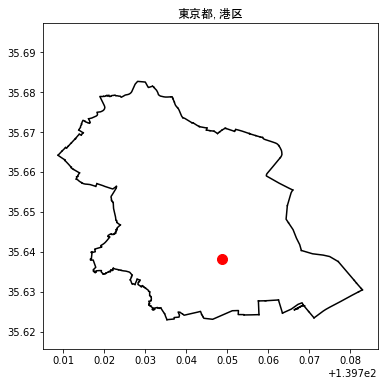

'{"request": {"requestTime": "2020-08-25T12:57:57", "lat": 35.638185, "lon": 139.748784}, "response": {"responseTime": "2020-08-25T12:57:57", "locations": [{"id": "1543125", "name": "東京都", "level": 4}, {"id": "1761717", "name": "港区", "level": 7}]}, "elapsedMilliseconds": 21}'

In [27]:
#test
lat = 35.638185 
lon = 139.748784

getLocationName(lat, lon)
